<a href="https://colab.research.google.com/github/solllull/entregasML/blob/main/tp2_experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TP 2: ENTRENAMIENTO Y EVALUACIÓN DE MODELOS**

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale
from datetime import datetime
from matplotlib import gridspec
import plotly.express as px
from matplotlib.lines import Line2D

from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns

from IPython.display import HTML, display
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
import graphviz  
from sklearn.tree import export_graphviz

In [ ]:
dataset = pd.read_csv('weatherAUS.csv')
dataset.shape

(145460, 23)

In [ ]:
# eliminación de filas con valores nulos
dataset = dataset.dropna(how='any',axis=0)
# convertir columna Date a tipo datetime
dataset['Date'] = pd.to_datetime(dataset['Date'])

**ELECCIÓN DE MÉTRICA**

Decidimos utilizar **Accuracy** como métrica para evaluar los modelos ya que predecir si va a llover o no al día siguiente no es algo crítico. Además queremos saber en qué porcentaje de casos, el modelo que entrenamos acertó, para lo cual esta métrica resulta adecuada para interpretarlo.

# **FEATURE ENGINEERING**


**Agregado de columna "Season"**

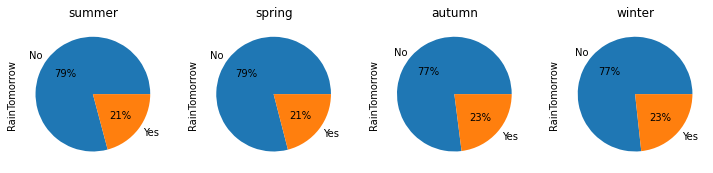

In [ ]:
# agregar columna "Season" (estación)
conditions_seasons = [
        (dataset['Date'].dt.month.isin([1, 2, 3])), # summer
        (dataset['Date'].dt.month.isin([4, 5, 6])), # autumn
        (dataset['Date'].dt.month.isin([7, 8, 9])), # winter
        (dataset['Date'].dt.month.isin([10, 11, 12])) # spring
]

seasons = ['summer', 'autumn', 'winter', 'spring']

# nueva columna Season
dataset['Season'] = np.select(conditions_seasons, seasons)

# cambiar season donde corresponda
dataset.Season.mask((dataset['Date'].dt.month == 12) & (dataset['Date'].dt.day > 20), 'summer', inplace=True)
dataset.Season.mask((dataset['Date'].dt.month == 3) & (dataset['Date'].dt.day > 20), 'autumn', inplace=True)
dataset.Season.mask((dataset['Date'].dt.month == 6) & (dataset['Date'].dt.day > 20), 'winter', inplace=True)
dataset.Season.mask((dataset['Date'].dt.month == 9) & (dataset['Date'].dt.day > 20), 'spring', inplace=True)

# Gráficos
fig2 = plt.figure(constrained_layout=True, figsize = (30,30))
spec2 = gridspec.GridSpec(ncols=6, nrows=7, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax4 = fig2.add_subplot(spec2[0, 3])
dataset[dataset.Season == 'summer'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax1, title = 'summer',figsize=(15,15))
dataset[dataset.Season == 'spring'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax2,title = 'spring',figsize=(15,15))
dataset[dataset.Season == 'autumn'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax3,title = 'autumn',figsize=(15,15))
dataset[dataset.Season == 'winter'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax4,title = 'winter',figsize=(15,15))

**Redondeo de valores numéricos**: sacamos precisión a los valores de columnas numéricas, redondeando a dos decimales.

In [ ]:
tmp = dataset.select_dtypes(include=[np.number])
dataset.loc[:, tmp.columns] = np.round(tmp, 2)

**División de columna "Date" en 3 nuevas columnas: Día, Mes y Año**

In [ ]:
# agregar columnas año, mes y día
dataset['Year'] = dataset['Date'].dt.year
dataset['Month'] = dataset['Date'].dt.month
dataset['Day'] = dataset['Date'].dt.day

dataset[['Date', 'Year', 'Month', 'Day']].sample(10)

,Date,Year,Month,Day
64942,2011-01-22,2011,1,22
70685,2009-10-20,2009,10,20
31962,2013-03-21,2013,3,21
79374,2012-11-16,2012,11,16
12830,2011-02-03,2011,2,3
95781,2016-01-04,2016,1,4
105582,2009-01-21,2009,1,21
93918,2010-08-31,2010,8,31
71569,2012-04-21,2012,4,21
104153,2013-08-17,2013,8,17


**Agregado de columna "Region"**

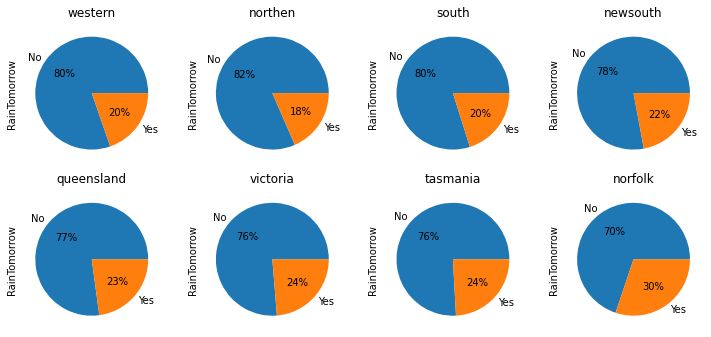

In [ ]:
conditions_regions = [
        (dataset['Location'].isin(['Perth', 'PerthAirport'])), # western
        (dataset['Location'].isin(['AliceSprings', 'Darwin'])), # northen
        (dataset['Location'].isin(['Woomera', 'Nuriootpa', 'MountGambier'])), # south
        (dataset['Location'].isin(['Mildura','Sale','WaggaWagga','Canberra','Sydney','SydneyAirport','Portland','Williamtown','CoffsHarbour','Moree','Cobar'])), # newsouth
        (dataset['Location'].isin(['Cairns', 'Townsville', 'Brisbane'])), # queensland
        (dataset['Location'].isin(['Watsonia','Melbourne','MelbourneAirport'])), # victoria
        (dataset['Location'].isin(['Hobart'])), # tasmania
        (dataset['Location'].isin(['NorfolkIsland'])) #norfolk
]

regions = ['western', 'northen', 'south', 'newsouth', 'queensland', 'victoria', 'tasmania', 'norfolk']

# nueva columna Region
dataset['Region'] = np.select(conditions_regions, regions)

#estos gráficos no hacen falta, los hice para ver qué onda nomás
fig2 = plt.figure(constrained_layout=True, figsize = (30,30))
spec2 = gridspec.GridSpec(ncols=6, nrows=7, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax4 = fig2.add_subplot(spec2[0, 3])
f2_ax5 = fig2.add_subplot(spec2[1, 0])
f2_ax6 = fig2.add_subplot(spec2[1, 1])
f2_ax7 = fig2.add_subplot(spec2[1, 2])
f2_ax8 = fig2.add_subplot(spec2[1, 3])
dataset[dataset.Region == 'western'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax1, title = 'western',figsize=(15,15))
dataset[dataset.Region == 'northen'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax2,title = 'northen',figsize=(15,15))
dataset[dataset.Region == 'south'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax3,title = 'south',figsize=(15,15))
dataset[dataset.Region == 'newsouth'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax4,title = 'newsouth',figsize=(15,15))
dataset[dataset.Region == 'queensland'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax5,title = 'queensland',figsize=(15,15))
dataset[dataset.Region == 'victoria'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax6,title = 'victoria',figsize=(15,15))
dataset[dataset.Region == 'tasmania'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax7,title = 'tasmania',figsize=(15,15))
dataset[dataset.Region == 'norfolk'].RainTomorrow.value_counts().sort_index().plot.pie(autopct='%1.0f%%', ax=f2_ax8,title = 'norfolk',figsize=(15,15))

**Unificación de valores en columnas "WindGustDir", "WindGustDir9am" y "WindGustDir3pm"**

In [ ]:
# Unificar valores columnas WindGustDir WindGustDir9am WindGustDir3pm

def conditions_dirs(column_name):
  conditions_dirs = [
        (dataset[column_name].isin(['N'])), # N
        (dataset[column_name].isin(['S'])), # S
        (dataset[column_name].isin(['E'])), # E
        (dataset[column_name].isin(['W'])), # W
        (dataset[column_name].isin(['NE', 'NNE', 'ENE'])), # NE
        (dataset[column_name].isin(['NW', 'WNW', 'NNW'])), # NW
        (dataset[column_name].isin(['SE', 'ESE', 'SSE'])), # SE
        (dataset[column_name].isin(['SW', 'SSW', 'WSW'])) # SW
    ]
  return conditions_dirs

dirs = ['N', 'S', 'E', 'W', 'NE', 'NW', 'SE', 'SW']

# nueva columna WindGustDir
dataset['WindGustDir'] = np.select(conditions_dirs('WindGustDir'), dirs)
dataset['WindDir9am'] = np.select(conditions_dirs('WindDir9am'), dirs)
dataset['WindDir3pm'] = np.select(conditions_dirs('WindDir3pm'), dirs)

dataset['WindGustDir'].unique()
dataset['WindDir9am'].unique()
dataset['WindDir3pm'].unique()

array(['SW', 'SE', 'NW', 'S', 'NE', 'N', 'E', 'W'], dtype=object)

In [ ]:
dataset.sample(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Season,Year,Month,Day,Region
36714,2009-07-05,WaggaWagga,4.0,11.7,0.0,1.0,9.3,SW,33.0,NW,SW,7.0,20.0,76.0,61.0,1019.9,1019.3,1.0,2.0,7.7,11.7,No,No,winter,2009,7,5,newsouth
107525,2014-08-15,Woomera,7.2,17.5,0.6,2.4,4.4,SE,41.0,SE,SE,26.0,24.0,75.0,54.0,1022.4,1019.0,2.0,8.0,10.5,16.0,No,No,winter,2014,8,15,south
70930,2010-06-22,Mildura,7.9,15.8,0.0,1.0,3.3,SE,24.0,NE,SE,9.0,15.0,84.0,48.0,1035.8,1033.1,7.0,7.0,9.9,15.4,No,No,winter,2010,6,22,newsouth
71275,2011-07-02,Mildura,7.2,20.9,0.0,4.0,3.5,NE,54.0,NE,N,24.0,31.0,62.0,33.0,1020.0,1014.8,5.0,7.0,11.3,20.3,No,Yes,winter,2011,7,2,newsouth
33355,2017-01-12,Sydney,22.3,28.4,0.0,9.4,7.2,E,31.0,SE,E,7.0,20.0,68.0,52.0,1012.4,1010.7,7.0,2.0,24.7,26.8,No,No,summer,2017,1,12,newsouth


In [ ]:
# eliminar columna Date y Location
dataset = dataset.drop(['Date'], axis=1)
dataset = dataset.drop(['Location'], axis=1)

#**ALGORITMOS**

Algoritmos a evaluar:

- Regresión logística
- Árboles de decisión 
- Random Forest
- Gradient Boosting 

**CONJUNTO DE DATOS (60% train, 20% test, 20% validation)**

In [ ]:
dataset['RainToday'] = dataset['RainToday'].map({"No":0, "Yes":1})
dataset['RainTomorrow'] = dataset['RainTomorrow'].map({"No":0, "Yes":1})

In [ ]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4, random_state=40)
validation, test = train_test_split(not_train, test_size=0.5, random_state=40)

train.shape, validation.shape, test.shape

((33852, 26), (11284, 26), (11284, 26))

In [ ]:
dataset.sample(5)

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Season,Year,Month,Day,Region
139945,22.5,31.7,8.0,3.8,4.3,NW,46.0,SE,NW,13.0,20.0,83.0,70.0,1012.0,1008.3,7.0,7.0,26.6,28.6,1,0,spring,2010,10,13,northen
86056,14.7,24.7,0.0,4.0,8.9,SE,28.0,SW,SE,9.0,13.0,63.0,47.0,1024.3,1021.1,2.0,7.0,19.9,23.4,0,0,autumn,2014,5,9,queensland
85165,12.4,22.5,0.0,9.4,11.5,W,48.0,SW,SW,15.0,20.0,40.0,30.0,1010.5,1009.0,1.0,5.0,17.9,20.8,0,0,spring,2011,10,2,queensland
67072,9.9,19.3,0.0,8.4,7.6,W,48.0,SW,S,17.0,26.0,60.0,43.0,1011.0,1010.7,1.0,7.0,13.8,16.6,0,0,summer,2017,2,18,victoria
33138,13.8,22.0,0.2,4.8,6.0,NW,59.0,NW,NW,31.0,17.0,62.0,32.0,1006.8,1005.9,7.0,1.0,17.4,21.6,0,0,autumn,2016,6,9,newsouth


**DATAFRAME MAPPER**

In [ ]:
mapper = DataFrameMapper([
    (['MinTemp'], [MinMaxScaler()]),
    (['MaxTemp'], [MinMaxScaler()]),
    (['Rainfall'], [MinMaxScaler()]),
    (['Evaporation'], [MinMaxScaler()]),
    (['Sunshine'], [MinMaxScaler()]),
    (['WindGustDir'], [OneHotEncoder()]),
    (['WindDir9am'], [OneHotEncoder()]),
    (['WindDir3pm'], [OneHotEncoder()]),
    (['WindGustSpeed'], [MinMaxScaler()]),
    (['WindSpeed9am'], [MinMaxScaler()]),
    (['WindSpeed3pm'], [MinMaxScaler()]),
    (['Humidity9am'], [MinMaxScaler()]),
    (['Humidity3pm'], [MinMaxScaler()]),
    (['Pressure9am'], [MinMaxScaler()]),
    (['Pressure3pm'], [MinMaxScaler()]),
    (['Cloud9am'], [MinMaxScaler()]),
    (['Cloud3pm'], [MinMaxScaler()]),
    (['Temp9am'], [MinMaxScaler()]),
    (['Temp3pm'], [MinMaxScaler()]),
    (['RainToday'], None),
    (['Season'], [OneHotEncoder()]),
    (['Year'], [MinMaxScaler()]),
    (['Month'], [MinMaxScaler()]),
    (['Day'], [MinMaxScaler()]),
    (['Region'], [OneHotEncoder()]),
])
sample = train.sample(5, random_state=42)
sample

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Season,Year,Month,Day,Region
32402,11.2,22.3,0.0,3.6,9.6,W,33.0,W,SE,24.0,13.0,69.0,53.0,1024.1,1022.9,1.0,3.0,13.6,22.0,0,1,autumn,2014,6,4,newsouth
119306,16.6,29.8,0.0,7.4,11.4,E,56.0,SE,SE,33.0,30.0,54.0,28.0,1021.2,1017.4,5.0,5.0,21.1,28.9,0,0,spring,2013,11,2,western
39910,20.7,27.0,0.0,6.6,8.1,SE,33.0,SE,SE,20.0,20.0,73.0,61.0,1020.6,1019.0,7.0,5.0,23.1,25.4,0,0,summer,2010,1,8,newsouth
138677,10.7,30.9,0.0,7.6,11.1,SW,35.0,NW,SE,6.0,13.0,34.0,12.0,1017.0,1012.2,3.0,1.0,20.7,30.1,0,0,autumn,2016,4,18,northen
120289,3.4,14.3,0.0,1.2,7.3,E,37.0,NE,NE,7.0,17.0,75.0,43.0,1030.7,1029.2,7.0,4.0,8.1,13.5,0,0,winter,2016,7,12,western


In [ ]:
mapper.fit(train)
# Sample transformado con el mapper completo
mapper.transform(sample)

array([[0.47091413, 0.4212963 , 0.        , 0.04433498, 0.66206897,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.19469027,
        0.33846154, 0.14864865, 0.68686869, 0.53      , 0.72909699,
        0.73781513, 0.125     , 0.33333333, 0.35660848, 0.43160377,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.7       , 0.45454545, 0.1       , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.62049861, 0.59490741, 0.        , 0.091133  , 0.7862069 ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.     

**Función para evaluar modelos**

In [ ]:
def evaluate_model(model, set_names=('train', 'validation'), title='', show_cm=True):
    if title:
        display(title)
        
    final_metrics = defaultdict(list)
    
    if show_cm:
        fig, axis = plt.subplots(1, len(set_names), sharey=True, figsize=(15, 3))
    
    for i, set_name in enumerate(set_names):
        assert set_name in ['train', 'validation', 'test']
        set_data = globals()[set_name] 

        y = set_data.RainTomorrow
        y_pred = model.predict(set_data)
        final_metrics['Accuracy'].append(metrics.accuracy_score(y, y_pred))
        final_metrics['Precision'].append(metrics.precision_score(y, y_pred))
        
        if show_cm:
            ax = axis[i]
            sns.heatmap(metrics.confusion_matrix(y, y_pred), ax=ax, cmap='Blues', annot=True, fmt='.0f', cbar=False)

            ax.set_title(set_name)
            ax.xaxis.set_ticklabels(['No', 'Yes'])
            ax.yaxis.set_ticklabels(['No', 'Yes'])
            ax.set_xlabel('Predicted class (RainTomorrow)')
            ax.set_ylabel('True class (RainTomorrow)')

        
    display(pd.DataFrame(final_metrics, index=set_names))
    if show_cm:
        plt.tight_layout()
        plt.show()

# **REGRESIÓN LOGÍSTICA**

In [ ]:
lr_model = Pipeline([
    ('mapper', mapper),
    ('classifier', LogisticRegression(random_state=40, max_iter=1000)),
])
lr_model.fit(train, train.RainTomorrow)

y_pred = lr_model.predict(validation)
y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
metrics.accuracy_score(validation.RainTomorrow, y_pred)

0.8559021623537753

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



,Accuracy,Precision
train,0.844677,0.704883
validation,0.846774,0.692265


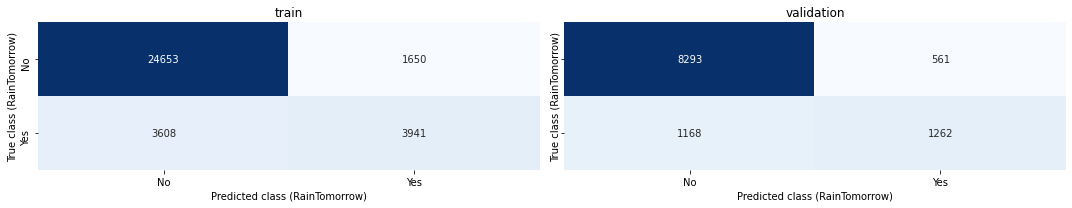

In [ ]:
lr_model2 = Pipeline([
    ('mapper', mapper),
    ('classifier', LogisticRegression(random_state=40, max_iter=10)),
])
lr_model2.fit(train, train.RainTomorrow)
evaluate_model(lr_model2)

,Accuracy,Precision
train,0.855164,0.736757
validation,0.855902,0.718716


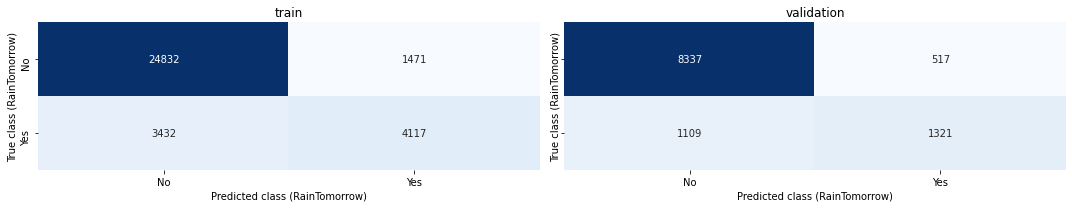

In [ ]:
evaluate_model(lr_model)

,Accuracy,Precision
train,0.854898,0.736079
validation,0.856257,0.720044


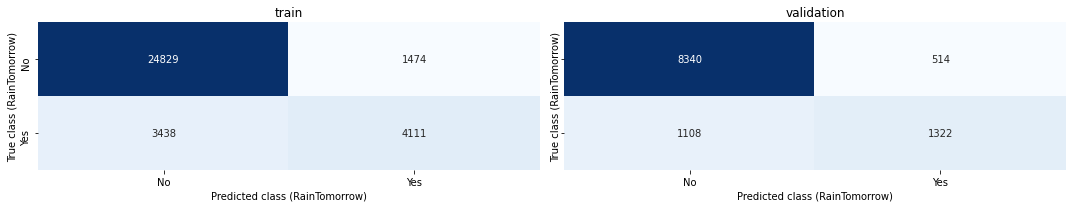

In [ ]:
lr_model3 = Pipeline([
    ('mapper', mapper),
    ('classifier', LogisticRegression(random_state=40, solver='liblinear')),
])
lr_model3.fit(train, train.RainTomorrow)
evaluate_model(lr_model3)

**Análisis de métricas**

Como se muestra en las tres celdas anteriores, evaluamos el modelo cambiando ciertos parámetros (max_iter y solver). En todos los casos obtuvimos resultados muy similares que interpretamos a continuación.



*   En cuanto a Accuracy, nos indica que el modelo acertó aproximadamente el 85% de los casos que predijo.
*   Si vemos Precision, nos indica que de los casos en los que lloverá al día siguiente (RainTomorrow = Yes), encontró el 73% de ellos.



In [ ]:
clf = lr_model.named_steps['classifier']
clf.coef_  # los pesos que aprendió la regresión logística
df_importance = pd.DataFrame({
    'feature': mapper.transformed_names_, 
    'coeficiente': clf.coef_[0],
}).sort_values(by='coeficiente')

df = px.data.tips()
fig = px.bar(df_importance, x='coeficiente', y='feature', orientation='h',
             height=1500,
             color = "coeficiente",
             title='Coeficientes')
fig.show()

**Análisis de gráfica de coeficientes**

Los coeficientes (o parámetros) de la función de salida nos dan "pistas" para interpretar la influencia de los mismos en la predicción.
En este caso, vemos que los valores que tomen las variables WindGustSpeed, Humidity3pm y Pressure9am, mientras mayores sean, más probabilidad habrá de que al día siguiente llueva (esto se observa en la parte superior del gráfico anterior).

Por otro lado, si observamos la parte inferior, podemos decir que mientras mayores sean los valores de Pressure3pm y Sunshine, menor será la probabilidad de que llueva al día siguiente (debido a que son parámetros con signo negativo).



# **ÁRBOLES DE DECISIÓN** 

'Decision Tree'

,Accuracy,Precision
train,1.000000,1.000000
validation,0.802907,0.540615


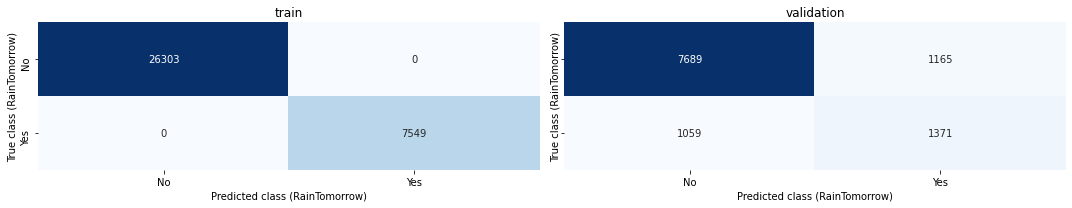

In [ ]:
tree_model1 = DecisionTreeClassifier(random_state=40)

dt_model1 = Pipeline([
                     ('mapper', mapper),
                     ('classifier', tree_model1),
])

history = dt_model1.fit(train, train.RainTomorrow)

evaluate_model(dt_model1, title='Decision Tree')

'Decision Tree'

,Accuracy,Precision
train,0.834781,0.776740
validation,0.838887,0.755853


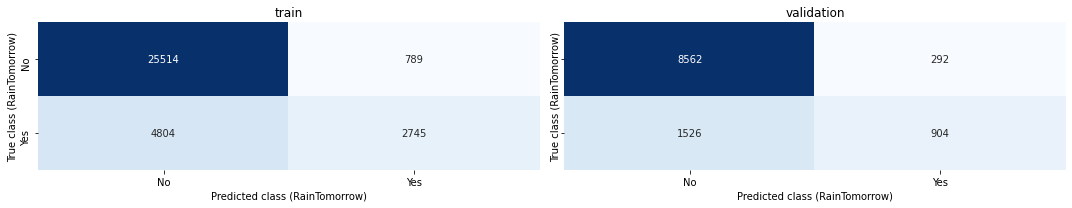

In [ ]:
tree_model = DecisionTreeClassifier(max_depth=3, random_state=40)

dt_model = Pipeline([
                     ('mapper', mapper),
                     ('classifier', tree_model),
])

history = dt_model.fit(train, train.RainTomorrow)

evaluate_model(dt_model, title='Decision Tree')

**Análisis de métricas**

Como se muestra en las celdas anteriores, se evaluó el algoritmo de Árboles de decisión de dos formas: sin establecer una profundidad máxima y estableciéndola. En el primer caso se observa que con el set de train sobreentenó debido a que tanto Accuracy como Precision devolvieron un valor de 1. En el set de validation esto no ocurrió.

Por otro lado, habiendo delimitado la profundidad máxima con un valor de 3, se obtuvieron métricas similares tanto para train como para validation. Accuracy nos indica que el modelo acertó en aproximadamente un 84% de los casos. Precision demuestra que el modelo encontró aproximadamente el 75% de los casos en los que al día siguiente lloverá.

In [ ]:
# Gráfico del árbol
def graph_tree(tree, col_names):
    graph_data = export_graphviz(
        tree, 
        out_file=None, 
        feature_names=col_names,  
        class_names=['died', 'survived'],  
        filled=True, 
        rounded=True,  
        special_characters=True,
    )
    graph = graphviz.Source(graph_data)  
    return graph

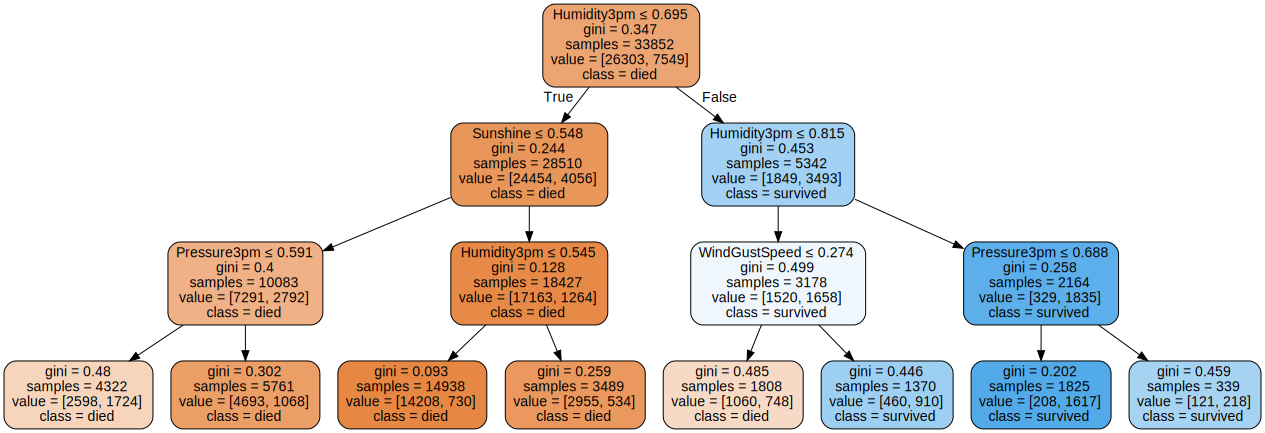

In [ ]:
graph_tree(tree_model, mapper.transformed_names_)

# **RANDOM FOREST**

'Random Forest'

,Accuracy,Precision
train,0.820070,0.833791
validation,0.825328,0.827389


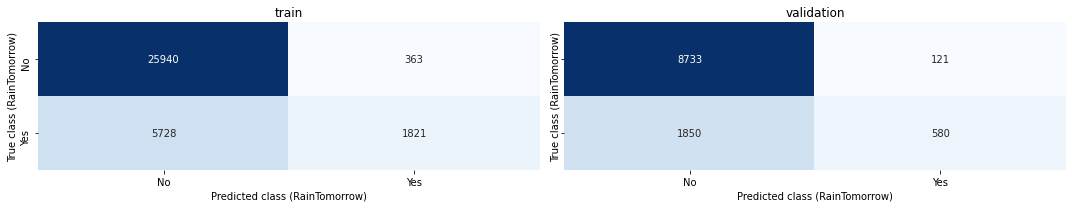

In [ ]:
forest_model = RandomForestClassifier(max_depth=3, random_state=40)

rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model),
])

rf_model.fit(train, train.RainTomorrow)

evaluate_model(rf_model, title='Random Forest')

'Random Forest'

,Accuracy,Precision
train,0.806540,0.915973
validation,0.813187,0.883333


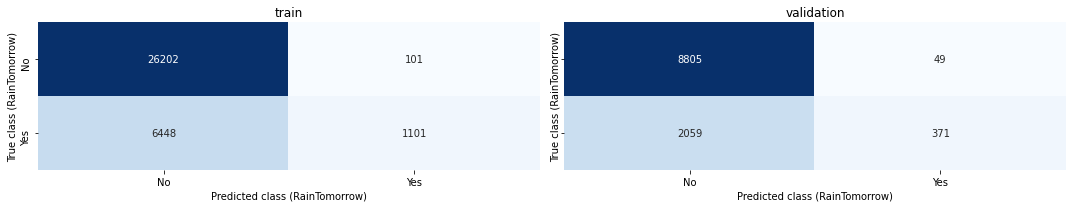

In [ ]:
forest_model = RandomForestClassifier(n_estimators=150, max_features=5, max_depth=3, random_state=40)

rf_model = Pipeline([
    ('mapper', mapper),
    ('classifier', forest_model),
])

rf_model.fit(train, train.RainTomorrow)

evaluate_model(rf_model, title='Random Forest')

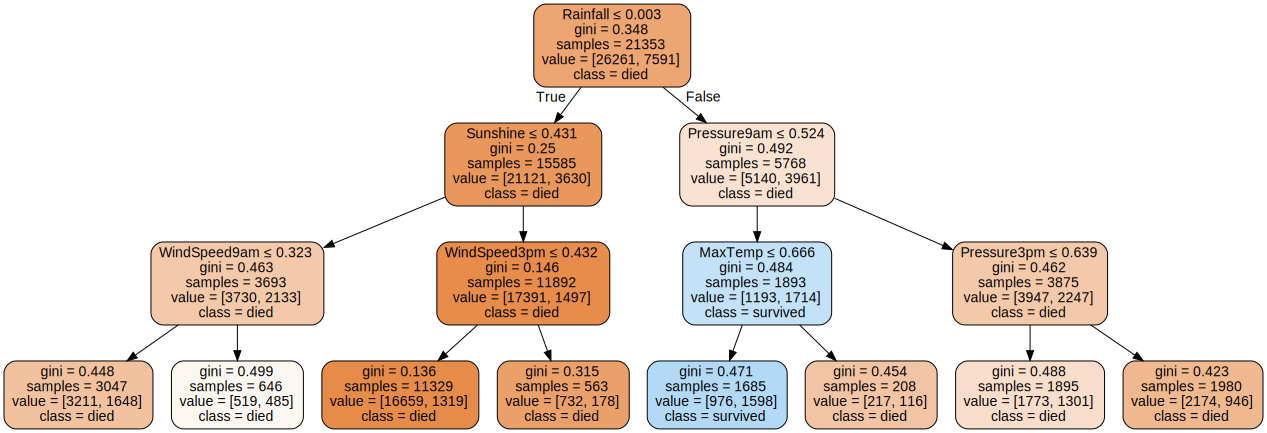

In [ ]:
graph_tree(forest_model.estimators_[0], mapper.transformed_names_)

**Análisis de métricas**

Con random forest probamos dos formas, una con el parámetro max_depth, y otra sumandole los parametros n_estimators y max_features. En el primero podemos ver que acertó con un 82% de todos los casos con accuracy y en precision, de los casos en los que sí iba a llover, acertó un 86%.

En el segundo, se puede ver que con accuracy acertó el 81% de los casos y un 90% con precision.
Es decir, ajustando los parámetros n_estimators y max_features logramos que mejore en precision, pero afecta apenas negativamente en accuracy.

Nos damos cuenta que no está sobreentrenando porque, a comparación del modelo anterior, la métrica tanto en train como en validation tienen valores similares y nunca nos arrojó como resultado 1.

# **GRADIENT BOOSTING**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

'Gradient Boosting'

,Accuracy,Precision
train,0.862992,0.762773
validation,0.862726,0.744586


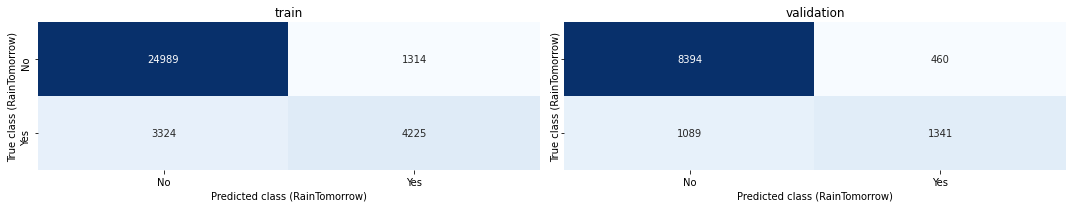

In [ ]:
boo_model = GradientBoostingClassifier(random_state=40)
boost_model = Pipeline([
    ('mapper', mapper),
    ('classifier', boo_model),
])

boost_model.fit(train, train.RainTomorrow)
evaluate_model(boost_model, title='Gradient Boosting')

'Gradient Boosting'

,Accuracy,Precision
train,0.851560,0.759671
validation,0.850939,0.739130


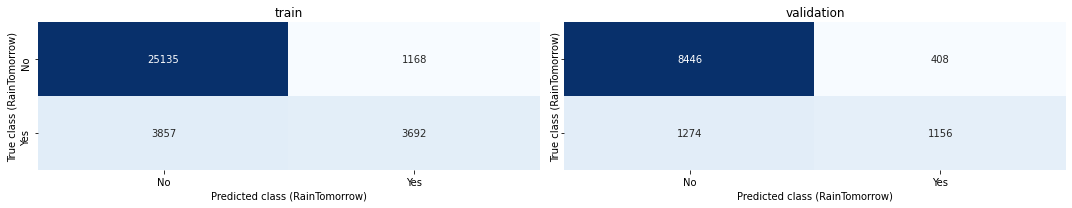

In [ ]:
boo_model = GradientBoostingClassifier(n_estimators=100, max_depth=3, max_features=2, random_state=40)
boost_model = Pipeline([
    ('mapper', mapper),
    ('classifier', boo_model),
])

boost_model.fit(train, train.RainTomorrow)
evaluate_model(boost_model, title='Gradient Boosting')

**Análisis de métricas**

Se realizó la evaluación del modelo con Gradient Boosting de dos maneras: sin limitar la cantidad de estimadores, profundidad de árboles y cantidad de features; y haciéndolo. Se puede observar que los resultados obtenidos de las métricas son muy similares, y que, para ambos casos, se puede decir que el modelo no esta sobreentrenando ya que los valores obtenidos tanto en test como en validation son cercanos.

Los resultados concluídos son:
- Accuracy nos indica que el modelo acertó el aproximadamente 86% de los casos que predijo.
- Precission nos indica que de los casos en los que lloverá al día siguiente (RainTomorrow = Yes), encontró el 75% de ellos.

**Gráfico del árbol**

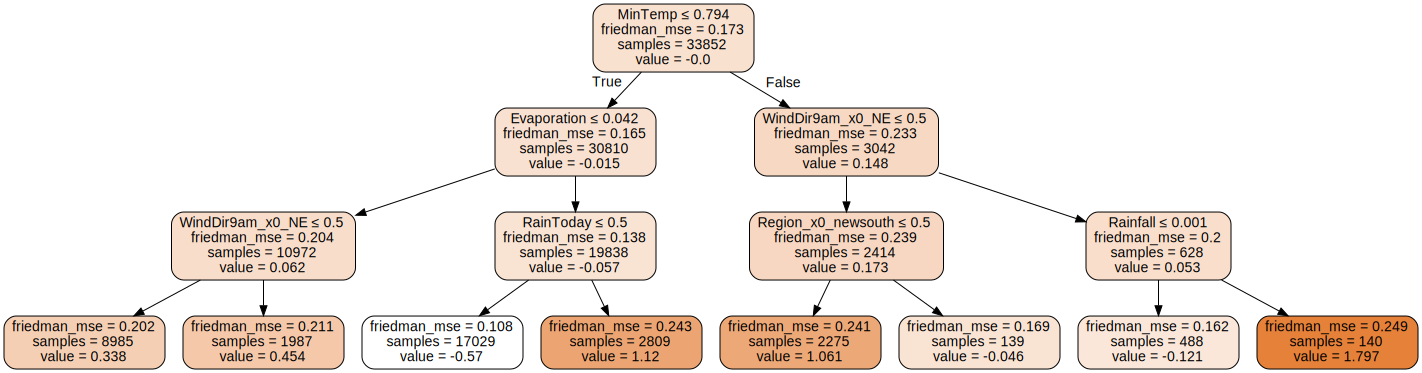

In [ ]:
graph_tree(boo_model.estimators_[1][0], col_names=mapper.transformed_names_)

# **VALOR FINAL DE MÉTRICA A INFORMAR AL CLIENTE**

Evaluamos los modelos nuevamente, ahora teniendo en cuenta el dataset de test.

In [ ]:
evaluate_model(lr_model, title='Logistic Regression', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(dt_model, title='Árboles de decisión', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(rf_model, title='Random Forest', set_names=('train', 'test', 'validation'), show_cm=False)
evaluate_model(boost_model, title='Gradient Boosting', set_names=('train', 'test', 'validation'), show_cm=False)

'Logistic Regression'

,Accuracy,Precision
train,0.855164,0.736757
test,0.857852,0.728850
validation,0.855902,0.718716


'Árboles de decisión'

,Accuracy,Precision
train,0.834781,0.776740
test,0.842077,0.778894
validation,0.838887,0.755853


'Random Forest'

,Accuracy,Precision
train,0.806540,0.915973
test,0.810440,0.877751
validation,0.813187,0.883333


'Gradient Boosting'

,Accuracy,Precision
train,0.851560,0.759671
test,0.853421,0.750631
validation,0.850939,0.739130


Habiendo evaluado el set de test vemos que todos los modelos arrojan valores similares. Aún así, consideramos elegir la métrica Accuracy porque el equivocarse en falsos positivos no tiene un alto impacto, a menos que el cliente le de importancia por alguna situación particular, por la cual le daríamos el porcentaje de Precision. 
Con respecto al modelo, elegimos Gradient Boosting ya que nos parece el más completo en tener en cuenta las fallas que se van cometiendo en cada árbol para aprender de estos errores. Además, a comparación de los demás modelos, posee uno de los porcentajes más altos de acierto. Por lo tanto, la métrica final a informar al cliente sería del 85%.